In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Datos
https://fred.stlouisfed.org/series/S4248SM144NCEN

In [2]:
df = pd.read_csv('/content/Alcohol_Sales.csv',index_col='DATE',parse_dates=True)
df.index.freq = 'MS'
df.columns = ['Sales']

In [3]:
df.head()

,Sales
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


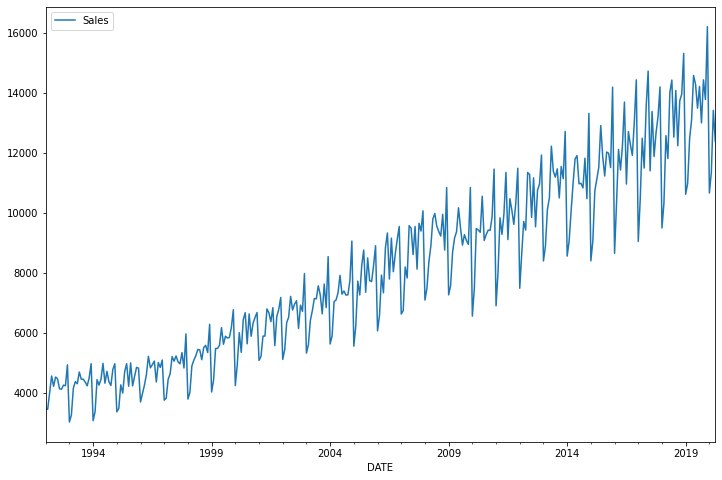

In [4]:
#Hacemos un gráfico de los datos
df.plot(figsize=(12,8))

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


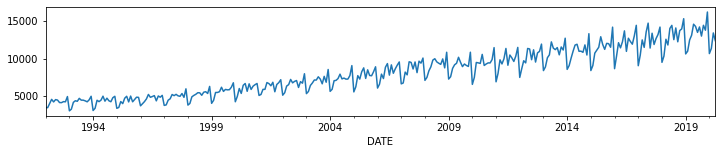

In [6]:
#Descomponemos la serie
results = seasonal_decompose(df['Sales'])
results.observed.plot(figsize=(12,2))

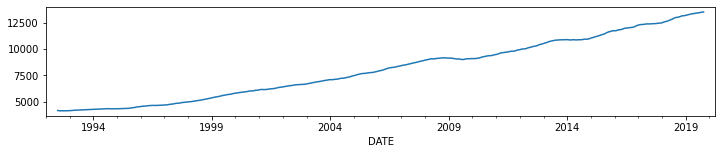

In [7]:
#Vemos el gráfico del componente de tendencia
results.trend.plot(figsize=(12,2))

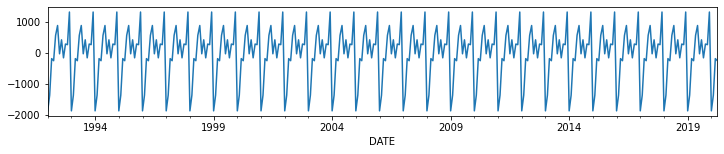

In [8]:
#Vemos el gráfico del componente de estacionalidad
results.seasonal.plot(figsize=(12,2))

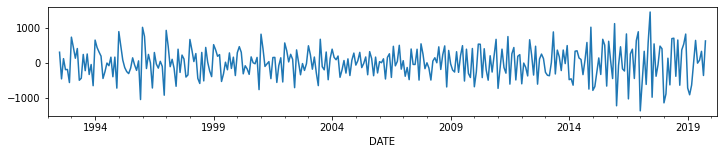

In [9]:
#Vemos el gráfico del componente residual
results.resid.plot(figsize=(12,2))

## Train Test Split

In [10]:
len(df)

340

In [11]:
len(df)-12 

328

In [12]:
#Hacemos el conjunto de entrenamiento y de prueba
train = df.iloc[:len(df)-12]
test = df.iloc[len(df)-12:]

In [13]:
len(test)

12

## Escalando los datos

Para una red neuronal se deben de escalar o normalizar los datos

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler()

In [16]:
#Ajustamos el minmax a los datos de entrenamiento, 
#para poder transformalos
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [17]:
#Transformamos los datos de entrenamiento y los de prueba
#scaler ya sabe transformar los datos
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

Este generador toma una secuencia de puntos de datos (como una sereie temporal) espaciados en intervalos iguales, teniendo en cuenta otros parámetros de series temporales, para producir batches para el entrenamiento / validación.

#### Argumentos
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [18]:
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [19]:
scaled_train

array([[0.03486194],
       [0.03478048],
       [0.07909098],
       [0.12486764],
       [0.09692922],
       [0.12201678],
       [0.11688523],
       [0.09008715],
       [0.08919117],
       [0.10002444],
       [0.09847683],
       [0.1551682 ],
       [0.        ],
       [0.01873422],
       [0.09196058],
       [0.1096359 ],
       [0.10393419],
       [0.13561945],
       [0.11623361],
       [0.11615215],
       [0.10857701],
       [0.09815101],
       [0.11965464],
       [0.15826342],
       [0.00358394],
       [0.02818278],
       [0.11501181],
       [0.10018734],
       [0.11639651],
       [0.1591594 ],
       [0.10531889],
       [0.13749287],
       [0.10939155],
       [0.09912845],
       [0.14278733],
       [0.15801906],
       [0.02761261],
       [0.03689827],
       [0.10083897],
       [0.07843936],
       [0.13716706],
       [0.15826342],
       [0.09709212],
       [0.1603812 ],
       [0.09806956],
       [0.12405311],
       [0.14824469],
       [0.146

In [20]:
# Definimos el generator
#n_input es el numeor de inputs
#n_features es el número de features
n_input = 2
n_features = 1
#Debemos de poner losparámetros
#data es el conjunto de datos escalado
#Esta misma es la fuente de objetivos, son las predicciones de validación
#length es el número de inputs
#batch size sera 1 o predicciones
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [21]:
len(scaled_train)

328

In [22]:
len(generator) # n_input = 2

326

In [23]:
#Vemos lor primeros datos de enrenamiento
scaled_train[:5]

array([[0.03486194],
       [0.03478048],
       [0.07909098],
       [0.12486764],
       [0.09692922]])

In [24]:
# ¿Cómo luce el primer batch?
generator[0]

(array([[[0.03486194],
         [0.03478048]]]), array([[0.07909098]]))

In [25]:
#Guardamos el valor de Generator[0]
X,y = generator[0]

In [26]:
print(f'Datos: \n{X.flatten()}')
print(f'Predicción: \n {y}')

Datos: 
[0.03486194 0.03478048]
Predicción: 
 [[0.07909098]]


In [27]:
# Vamos a redefinir para que utilice 12 meses y luego prediga el próximo mes
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [28]:
# ¿Cómo luce el primer batch?
X,y = generator[0]

In [29]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.03486194 0.03478048 0.07909098 0.12486764 0.09692922 0.12201678
 0.11688523 0.09008715 0.08919117 0.10002444 0.09847683 0.1551682 ]
Predict this y: 
 [[0.]]


### Creando el Modelo

In [30]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [31]:
# define model
#Vamos a añadir las capas al modelo
model = Sequential()
#La primera capa debe de ser una LSTM, junto a las neuronas a utilizar
#Por último, especificamos la dimensión de entrada
#Esto debe de ir siempre en la primer capa
#En este caso, la dimensión es la del Generator
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
#Luego del LSTM, se agrega una capa densa en una sola predicción
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [33]:
# fit model
#Vamos a ajustar el generator
#Así como el número de veces que queremos que reocrra el modelo
model.fit_generator(generator,epochs=50)

Epoch 1/50
316/316 [==============================] - 2s 8ms/step - loss: 0.0182
Epoch 2/50
316/316 [==============================] - 2s 6ms/step - loss: 0.0091
Epoch 3/50
316/316 [==============================] - 2s 6ms/step - loss: 0.0080
Epoch 4/50
316/316 [==============================] - 2s 6ms/step - loss: 0.0074
Epoch 5/50
316/316 [==============================] - 2s 5ms/step - loss: 0.0074
Epoch 6/50
316/316 [==============================] - 2s 6ms/step - loss: 0.0053
Epoch 7/50
316/316 [==============================] - 2s 6ms/step - loss: 0.0051
Epoch 8/50
316/316 [==============================] - 2s 6ms/step - loss: 0.0032
Epoch 9/50
316/316 [==============================] - 2s 6ms/step - loss: 0.0030
Epoch 10/50
316/316 [==============================] - 2s 6ms/step - loss: 0.0025
Epoch 11/50
316/316 [==============================] - 2s 6ms/step - loss: 0.0022
Epoch 12/50
316/316 [==============================] - 2s 6ms/step - loss: 0.0019
Epoch 13/50
316/316 [====

In [34]:
model.history.history.keys()

dict_keys(['loss'])

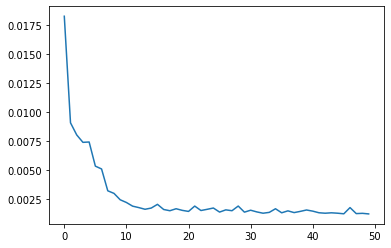

In [35]:
#Graficamos los errores y los epocs
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

## Evaluando en los Datos de Prueba (Test)

In [36]:
# 12 meses de historia ---> predecir el 13
# Necesitaremos los últimos 12 meses del conjunto de entrenamiento para predecir el 1er mes en el conjunto de prueba
#Obtenemos lo últimos 12 meses del conjunto de entrenamiento
first_eval_batch = scaled_train[-12:]

In [38]:
first_eval_batch

array([[0.89443675],
       [0.92766963],
       [0.77274578],
       [0.89940539],
       [0.74936874],
       [0.87122261],
       [0.8893052 ],
       [1.        ],
       [0.61782194],
       [0.64714507],
       [0.76899894],
       [0.8199886 ]])

In [39]:
X.shape

(1, 12, 1)

In [40]:
#Hacemos un reshape
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [41]:
first_eval_batch.shape

(1, 12, 1)

In [42]:
#Hacemos la predicción con el first_eval
model.predict(first_eval_batch)

array([[0.9203329]], dtype=float32)

In [43]:
#Vemos los datos de prueba
#La predicción debe de ser la primer entrada del conjunto de prueba
scaled_test

array([[0.94013195],
       [0.91602183],
       [0.8514295 ],
       [0.9101572 ],
       [0.81135457],
       [0.9282398 ],
       [0.87496946],
       [1.07241183],
       [0.62132443],
       [0.67760854],
       [0.84540197],
       [0.76134235]])

Ahora pongamos esta lógica en un bucle for para predecir el futuro para todo el rango de prueba.
----

In [44]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    #Solo queremos el valor de la primer posici´on, solo es el número
    current_pred = model.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [45]:
test_predictions

[array([0.9203329], dtype=float32),
 array([0.9322121], dtype=float32),
 array([0.823376], dtype=float32),
 array([0.91430837], dtype=float32),
 array([0.79710513], dtype=float32),
 array([0.91031957], dtype=float32),
 array([0.92358613], dtype=float32),
 array([1.0130426], dtype=float32),
 array([0.65537214], dtype=float32),
 array([0.7205681], dtype=float32),
 array([0.8035891], dtype=float32),
 array([0.8698028], dtype=float32)]

In [46]:
#Este es ek vector de los datos de prueba
scaled_test

array([[0.94013195],
       [0.91602183],
       [0.8514295 ],
       [0.9101572 ],
       [0.81135457],
       [0.9282398 ],
       [0.87496946],
       [1.07241183],
       [0.62132443],
       [0.67760854],
       [0.84540197],
       [0.76134235]])

## Transformación inversa y Comparación

In [47]:
#Hacemos la transformaci+on inversa de las predicciones
true_predictions = scaler.inverse_transform(test_predictions)

In [48]:
true_predictions

array([[14329.92711926],
       [14475.76812768],
       [13139.58715111],
       [14255.96384817],
       [12817.05972439],
       [14206.9933207 ],
       [14369.86691976],
       [15468.12362158],
       [11077.00379705],
       [11877.41481513],
       [12896.66344953],
       [13709.56864411]])

In [49]:
#Vemos los datos de prueba que tenemos originalmente
test

,Sales
DATE,
2019-05-01,14573
2019-06-01,14277
2019-07-01,13484
2019-08-01,14205
2019-09-01,12992
2019-10-01,14427
2019-11-01,13773
2019-12-01,16197
2020-01-01,10659


In [50]:
#Agregamos las predicciones junto a los datos de prueba
test['Predictions'] = true_predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [51]:
test

,Sales,Predictions
DATE,,
2019-05-01,14573,14329.927119
2019-06-01,14277,14475.768128
2019-07-01,13484,13139.587151
2019-08-01,14205,14255.963848
2019-09-01,12992,12817.059724
2019-10-01,14427,14206.993321
2019-11-01,13773,14369.866920
2019-12-01,16197,15468.123622
2020-01-01,10659,11077.003797


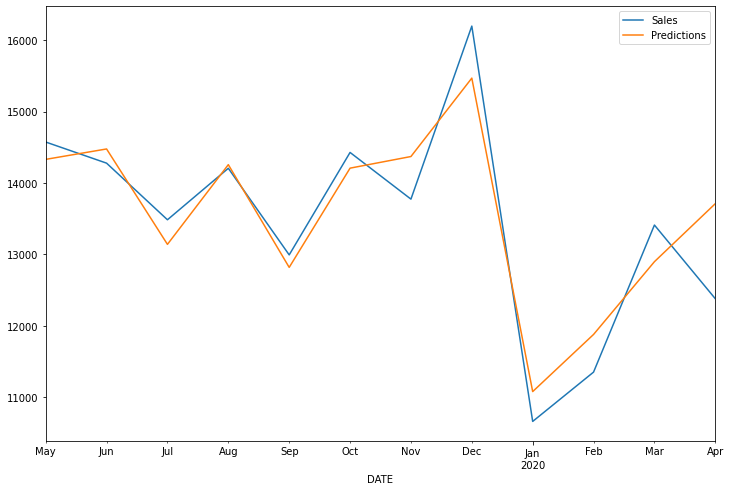

In [52]:
#Hacemos un gráfico para comparar ambos conjutnos de datos
test.plot(figsize=(12,8))

# Guardar un Modelo

In [53]:
model.save('my_rnn_model.h5')

# Cargar un Modelo

In [54]:
from keras.models import load_model
new_model = load_model('my_rnn_model.h5')

In [55]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
